In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras 
from tensorflow.keras import layers
import matplotlib.pyplot as plt

## Clip Constrainst

In [2]:
class ClipConstraint(keras.constraints.Constraint):
  def __init__(self, clip_value):
    self.clip_value = clip_value

  def __call__(self, weights):
    return keras.backend.clip(weights, -self.clip_value, self.clip_value)

  def get_config(self):
    return {'clip_value': self.clip_value}

## Wasserstein loss

In [3]:
def wasserstein_loss(y_true, y_pred):
  return keras.backend.mean(y_true * y_pred)

## Critic

In [4]:
def define_critic(in_shape=(28, 28, 1)):
  init = keras.initializers.RandomNormal(stddev=0.02)
  const = ClipConstraint(0.01)
  model = keras.Sequential()
  model.add(layers.Conv2D(64, (4, 4), strides=(2, 2), padding='same', kernel_initializer=keras.initializers.RandomNormal(stddev=0.02), kernel_constraint=const, input_shape=in_shape))
  model.add(layers.BatchNormalization())
  model.add(layers.LeakyReLU(alpha=0.2))
  model.add(layers.Conv2D(64, (4, 4), strides=(2, 2), padding='same', kernel_initializer=keras.initializers.RandomNormal(stddev=0.02), kernel_constraint=const))
  model.add(layers.BatchNormalization())
  model.add(layers.LeakyReLU(alpha=0.2))
  model.add(layers.Flatten())
  model.add(layers.Dense(1))
  model.compile(loss=wasserstein_loss, optimizer=keras.optimizers.RMSprop(learning_rate=0.00005))
  return model

## Generator

In [5]:
def define_generator(latent_dim):
  init = keras.initializers.RandomNormal(stddev=0.02)
  model = keras.Sequential()
  n_nodes = 128 * 7 * 7
  model.add(layers.Dense(n_nodes, kernel_initializer=keras.initializers.RandomNormal(stddev=0.02), input_dim=latent_dim))
  model.add(layers.LeakyReLU(alpha=0.2))
  model.add(layers.Reshape((7, 7, 128)))
  model.add(layers.Conv2DTranspose(128, (4, 4), strides=(2, 2), padding='same', kernel_initializer=keras.initializers.RandomNormal(stddev=0.02)))
  model.add(layers.BatchNormalization())
  model.add(layers.LeakyReLU(alpha=0.2))
  model.add(layers.Conv2DTranspose(128, (4, 4), strides=(2, 2), padding='same', kernel_initializer=keras.initializers.RandomNormal(stddev=0.02)))
  model.add(layers.BatchNormalization())
  model.add(layers.LeakyReLU(alpha=0.2))
  model.add(layers.Conv2D(1, (7, 7), activation='tanh', padding='same', kernel_initializer=init))
  return model

## GAN

In [6]:
def define_gan(generator, critic):
  critic.trainable = False
  model = keras.Sequential()
  model.add(generator)
  model.add(critic)
  model.compile(loss=wasserstein_loss, optimizer=keras.optimizers.RMSprop(learning_rate=0.00005))
  return model

## Utility Functions

In [7]:
def load_real_samples():
  (x_train, y_train), (_, _) = keras.datasets.mnist.load_data()
  selected_ix = y_train == 7
  x = x_train[selected_ix]
  x = np.expand_dims(x, axis=-1)
  x = x.astype('float32')
  x = (x - 127.5) / 127.5
  return x

def generate_real_samples(dataset, n_samples):
  ix = np.random.randint(0, dataset.shape[0], n_samples)
  x = dataset[ix]
  y = -np.ones((n_samples, 1))
  return x, y

def generate_latent_points(latent_dim, n_samples):
  x_input = np.random.randn(latent_dim * n_samples)
  x_input = x_input.reshape(n_samples, latent_dim)
  return x_input

def generate_fake_samples(generator, latent_dim, n_samples):
  x_input = generate_latent_points(latent_dim, n_samples)
  x = generator.predict(x_input)
  y = np.ones((n_samples, 1))
  return x, y

def summarize_performance(step, g_model, latent_dim, n_samples=100):
  x, _ = generate_fake_samples(g_model, latent_dim, n_samples)
  x = (x + 1) / 2.0
  for i in range(10 * 10):
    plt.subplot(10, 10, 1 + i)
    plt.axis('off')
    plt.imshow(x[i, :, :, 0], cmap='gray_r')
  filename1 = 'generated_plot_%04d.png' % (step+1)
  plt.savefig(filename1)
  plt.close()
  filename2 = 'model_%04d.h5' % (step+1)
  g_model.save(filename2)
  print('>Saved: %s and %s' % (filename1, filename2))

def plot_history(d1_hist,  d2_hist, g_hist):
  plt.plot(d1_hist, label='critic_real')
  plt.plot(d2_hist, label='critic_fake')
  plt.plot(g_hist, label='generator')
  plt.legend()
  plt.savefig('plot_line_plot_loss.png')
  plt.close()

## Train the GAN

In [8]:
def train(g_model, c_model, gan_model, dataset, latent_dim, n_epochs=10, n_batch=64, n_critic=5):
  bat_per_epo = int(dataset.shape[0] / n_batch)
  n_steps = bat_per_epo * n_epochs
  half_batch = int(n_batch / 2)
  c1_hist, c2_hist, g_hist = list(), list(), list()
  for i in range(n_steps):
    c1_temp, c2_temp = list(), list()
    for _ in range(n_critic):
      x_real, y_real = generate_real_samples(dataset, half_batch)
      c_loss1 = c_model.train_on_batch(x_real, y_real)
      c1_temp.append(c_loss1)
      x_fake, y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
      c_loss2 = c_model.train_on_batch(x_fake, y_fake)
      c2_temp.append(c_loss2)
    c1_hist.append(np.mean(c1_temp))
    c2_hist.append(np.mean(c2_temp))
    x_gan = generate_latent_points(latent_dim, n_batch)
    y_gan = -np.ones((n_batch, 1))
    g_loss = gan_model.train_on_batch(x_gan, y_gan)
    g_hist.append(g_loss)
    print('>%d, c1=%.3f, c2=%.3f, g=%.3f' % (i+1, c1_hist[-1], c2_hist[-1], g_loss))
    if (i+1) % bat_per_epo == 0:
      summarize_performance(i, g_model, latent_dim)
  plot_history(c1_hist, c2_hist, g_hist)

In [9]:
latent_dim = 50
critic = define_critic()
generator = define_generator(latent_dim)
gan_model = define_gan(generator, critic)
dataset = load_real_samples()
print(dataset.shape)
train(generator, critic, gan_model, dataset, latent_dim)

11490434/11490434 [==============================] - 0s 0us/step
(6265, 28, 28, 1)
1/1 [==============================] - 0s 15ms/step
>1, c1=-2.256, c2=0.013, g=0.001
1/1 [==============================] - 0s 23ms/step
>2, c1=-6.577, c2=0.013, g=-0.003
1/1 [==============================] - 0s 23ms/step
>3, c1=-10.041, c2=0.028, g=-0.008
1/1 [==============================] - 0s 23ms/step
>4, c1=-11.960, c2=0.055, g=-0.014
1/1 [==============================] - 0s 17ms/step
>5, c1=-14.320, c2=0.088, g=-0.021
1/1 [==============================] - 0s 16ms/step
>6, c1=-15.574, c2=0.130, g=-0.028
1/1 [==============================] - 0s 26ms/step
>7, c1=-17.085, c2=0.153, g=-0.037
1/1 [==============================] - 0s 16ms/step
>8, c1=-18.639, c2=0.167, g=-0.047
1/1 [==============================] - 0s 15ms/step
>9, c1=-19.917, c2=0.191, g=-0.058
1/1 [==============================] - 0s 18ms/step
>10, c1=-20.942, c2=0.183, g=-0.075
1/1 [==============================] - 0s 15ms/st

>Saved: generated_plot_0097.png and model_0097.h5
1/1 [==============================] - 0s 18ms/step
>98, c1=-77.006, c2=-69.359, g=-71.486
1/1 [==============================] - 0s 16ms/step
>99, c1=-77.967, c2=-70.010, g=-72.590
1/1 [==============================] - 0s 16ms/step
>100, c1=-78.100, c2=-70.820, g=-71.489
1/1 [==============================] - 0s 18ms/step
>101, c1=-78.935, c2=-71.464, g=-73.369
1/1 [==============================] - 0s 16ms/step
>102, c1=-79.720, c2=-72.174, g=-70.577
1/1 [==============================] - 0s 17ms/step
>103, c1=-81.055, c2=-72.944, g=-71.500
1/1 [==============================] - 0s 16ms/step
>104, c1=-81.193, c2=-73.614, g=-69.173
1/1 [==============================] - 0s 16ms/step
>105, c1=-81.923, c2=-74.280, g=-67.177
1/1 [==============================] - 0s 16ms/step
>106, c1=-82.759, c2=-74.972, g=-67.245
1/1 [==============================] - 0s 23ms/step
>107, c1=-83.443, c2=-75.411, g=-70.498
1/1 [===========================

>Saved: generated_plot_0194.png and model_0194.h5
1/1 [==============================] - 0s 26ms/step
>195, c1=-150.713, c2=-141.658, g=-194.041
1/1 [==============================] - 0s 24ms/step
>196, c1=-151.355, c2=-142.446, g=-204.709
1/1 [==============================] - 0s 17ms/step
>197, c1=-152.895, c2=-143.234, g=-219.103
1/1 [==============================] - 0s 17ms/step
>198, c1=-153.115, c2=-144.052, g=-227.266
1/1 [==============================] - 0s 23ms/step
>199, c1=-155.482, c2=-144.848, g=-223.974
1/1 [==============================] - 0s 21ms/step
>200, c1=-154.742, c2=-145.649, g=-232.290
1/1 [==============================] - 0s 18ms/step
>201, c1=-156.427, c2=-146.545, g=-232.226
1/1 [==============================] - 0s 25ms/step
>202, c1=-156.642, c2=-147.327, g=-231.915
1/1 [==============================] - 0s 19ms/step
>203, c1=-158.164, c2=-148.192, g=-249.498
1/1 [==============================] - 0s 16ms/step
>204, c1=-159.158, c2=-148.997, g=-248.512


>Saved: generated_plot_0291.png and model_0291.h5
1/1 [==============================] - 0s 18ms/step
>292, c1=-237.842, c2=-225.866, g=-413.574
1/1 [==============================] - 0s 27ms/step
>293, c1=-238.922, c2=-226.790, g=-409.168
1/1 [==============================] - 0s 20ms/step
>294, c1=-240.615, c2=-227.784, g=-407.168
1/1 [==============================] - 0s 18ms/step
>295, c1=-240.624, c2=-228.526, g=-390.476
1/1 [==============================] - 0s 19ms/step
>296, c1=-241.916, c2=-229.448, g=-407.169
1/1 [==============================] - 0s 16ms/step
>297, c1=-243.711, c2=-230.504, g=-417.893
1/1 [==============================] - 0s 17ms/step
>298, c1=-244.492, c2=-231.508, g=-413.631
1/1 [==============================] - 0s 15ms/step
>299, c1=-246.228, c2=-232.413, g=-415.111
1/1 [==============================] - 0s 15ms/step
>300, c1=-246.495, c2=-233.489, g=-405.856
1/1 [==============================] - 0s 18ms/step
>301, c1=-246.364, c2=-234.184, g=-418.656


>Saved: generated_plot_0388.png and model_0388.h5
1/1 [==============================] - 0s 27ms/step
>389, c1=-324.493, c2=-315.457, g=-109.999
1/1 [==============================] - 0s 17ms/step
>390, c1=-329.060, c2=-317.818, g=-140.743
1/1 [==============================] - 0s 19ms/step
>391, c1=-326.738, c2=-319.150, g=-146.379
1/1 [==============================] - 0s 17ms/step
>392, c1=-329.415, c2=-320.200, g=-138.048
1/1 [==============================] - 0s 20ms/step
>393, c1=-333.378, c2=-319.900, g=-146.860
1/1 [==============================] - 0s 18ms/step
>394, c1=-334.320, c2=-321.832, g=-148.832
1/1 [==============================] - 0s 16ms/step
>395, c1=-334.274, c2=-320.150, g=-124.689
1/1 [==============================] - 0s 16ms/step
>396, c1=-334.536, c2=-321.150, g=-100.652
1/1 [==============================] - 0s 17ms/step
>397, c1=-335.057, c2=-322.662, g=-102.268
1/1 [==============================] - 0s 19ms/step
>398, c1=-337.330, c2=-322.761, g=-111.981


>Saved: generated_plot_0485.png and model_0485.h5
1/1 [==============================] - 0s 22ms/step
>486, c1=-427.605, c2=-419.278, g=3.585
1/1 [==============================] - 0s 19ms/step
>487, c1=-430.136, c2=-420.453, g=7.405
1/1 [==============================] - 0s 19ms/step
>488, c1=-431.351, c2=-422.082, g=9.819
1/1 [==============================] - 0s 21ms/step
>489, c1=-433.104, c2=-423.859, g=5.789
1/1 [==============================] - 0s 20ms/step
>490, c1=-434.918, c2=-423.855, g=14.386
1/1 [==============================] - 0s 26ms/step
>491, c1=-436.252, c2=-424.776, g=12.894
1/1 [==============================] - 0s 27ms/step
>492, c1=-438.448, c2=-427.363, g=14.010
1/1 [==============================] - 0s 23ms/step
>493, c1=-439.185, c2=-428.159, g=8.412
1/1 [==============================] - 0s 24ms/step
>494, c1=-441.309, c2=-429.687, g=17.651
1/1 [==============================] - 0s 17ms/step
>495, c1=-441.355, c2=-431.026, g=28.991
1/1 [====================

>Saved: generated_plot_0582.png and model_0582.h5
1/1 [==============================] - 0s 16ms/step
>583, c1=-562.958, c2=-536.494, g=56.590
1/1 [==============================] - 0s 16ms/step
>584, c1=-563.374, c2=-538.054, g=69.028
1/1 [==============================] - 0s 18ms/step
>585, c1=-564.720, c2=-539.248, g=68.430
1/1 [==============================] - 0s 16ms/step
>586, c1=-566.570, c2=-538.843, g=60.325
1/1 [==============================] - 0s 16ms/step
>587, c1=-567.435, c2=-540.676, g=66.754
1/1 [==============================] - 0s 16ms/step
>588, c1=-568.179, c2=-543.727, g=64.325
1/1 [==============================] - 0s 17ms/step
>589, c1=-569.965, c2=-545.073, g=74.288
1/1 [==============================] - 0s 21ms/step
>590, c1=-570.693, c2=-547.078, g=61.077
1/1 [==============================] - 0s 16ms/step
>591, c1=-572.650, c2=-548.665, g=66.652
1/1 [==============================] - 0s 20ms/step
>592, c1=-573.186, c2=-550.399, g=54.478
1/1 [===============

>Saved: generated_plot_0679.png and model_0679.h5
1/1 [==============================] - 0s 20ms/step
>680, c1=-694.703, c2=-663.372, g=102.542
1/1 [==============================] - 0s 18ms/step
>681, c1=-696.284, c2=-665.601, g=105.500
1/1 [==============================] - 0s 16ms/step
>682, c1=-698.621, c2=-667.810, g=92.797
1/1 [==============================] - 0s 16ms/step
>683, c1=-699.369, c2=-665.775, g=107.143
1/1 [==============================] - 0s 16ms/step
>684, c1=-701.221, c2=-669.037, g=91.120
1/1 [==============================] - 0s 19ms/step
>685, c1=-702.661, c2=-670.049, g=91.783
1/1 [==============================] - 0s 17ms/step
>686, c1=-704.861, c2=-672.499, g=102.798
1/1 [==============================] - 0s 17ms/step
>687, c1=-705.351, c2=-672.908, g=89.617
1/1 [==============================] - 0s 17ms/step
>688, c1=-706.277, c2=-675.507, g=74.109
1/1 [==============================] - 0s 16ms/step
>689, c1=-708.687, c2=-675.749, g=95.565
1/1 [===========

>Saved: generated_plot_0776.png and model_0776.h5
1/1 [==============================] - 0s 20ms/step
>777, c1=-837.671, c2=-796.439, g=97.242
1/1 [==============================] - 0s 20ms/step
>778, c1=-841.106, c2=-796.257, g=127.165
1/1 [==============================] - 0s 27ms/step
>779, c1=-844.179, c2=-798.675, g=121.335
1/1 [==============================] - 0s 29ms/step
>780, c1=-843.910, c2=-799.404, g=126.435
1/1 [==============================] - 0s 26ms/step
>781, c1=-845.728, c2=-801.920, g=126.694
1/1 [==============================] - 0s 19ms/step
>782, c1=-846.177, c2=-801.694, g=118.462
1/1 [==============================] - 0s 18ms/step
>783, c1=-846.824, c2=-804.731, g=125.527
1/1 [==============================] - 0s 16ms/step
>784, c1=-849.559, c2=-804.456, g=97.772
1/1 [==============================] - 0s 19ms/step
>785, c1=-851.534, c2=-807.094, g=109.042
1/1 [==============================] - 0s 17ms/step
>786, c1=-854.074, c2=-807.037, g=121.373
1/1 [=======

>Saved: generated_plot_0873.png and model_0873.h5
1/1 [==============================] - 0s 17ms/step
>874, c1=-992.497, c2=-938.168, g=116.793
1/1 [==============================] - 0s 16ms/step
>875, c1=-994.895, c2=-941.250, g=119.837
1/1 [==============================] - 0s 18ms/step
>876, c1=-996.512, c2=-940.254, g=103.026
1/1 [==============================] - 0s 18ms/step
>877, c1=-997.972, c2=-939.822, g=156.389
1/1 [==============================] - 0s 16ms/step
>878, c1=-999.285, c2=-935.949, g=158.018
1/1 [==============================] - 0s 16ms/step
>879, c1=-1000.799, c2=-943.492, g=135.855
1/1 [==============================] - 0s 18ms/step
>880, c1=-1001.764, c2=-945.879, g=154.918
1/1 [==============================] - 0s 17ms/step
>881, c1=-1002.867, c2=-949.767, g=147.088
1/1 [==============================] - 0s 18ms/step
>882, c1=-1005.528, c2=-951.390, g=154.059
1/1 [==============================] - 0s 18ms/step
>883, c1=-1005.610, c2=-953.930, g=157.157
1/1 [

>Saved: generated_plot_0970.png and model_0970.h5


1/1 [==============================] - 0s 395ms/step


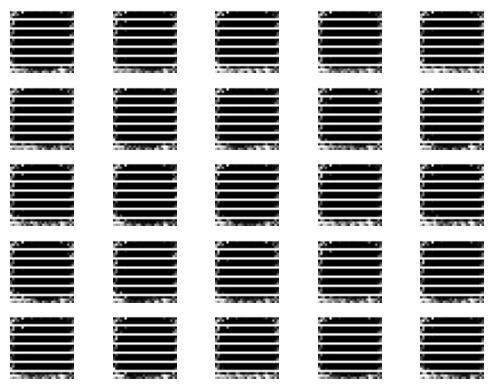

In [10]:
def generate_latent_points(latent_dim, n_samples): 
  # generate points in the latent space 
  x_input = np.random.randn(latent_dim * n_samples) 
  # reshape into a batch of inputs for the network 
  x_input = x_input.reshape(n_samples, latent_dim)
  return x_input

def plot_generated(examples, n): 
  # plot images 
  for i in range(n * n): 
    # define subplot 
    plt.subplot(n, n, 1 + i) 
    # turn off axis 
    plt.axis('off') 
    # plot raw pixel data 
    plt.imshow(examples[i, :, :, 0], cmap='gray_r')
plt.show()

model = keras.models.load_model('model_0970.h5') 
# generate images 
latent_points = generate_latent_points(50, 25) 
# generate images 
X = model.predict(latent_points) 
# plot the result
plot_generated(X, 5)